<a href="https://colab.research.google.com/github/gopaps/MachineLearning/blob/main/week%2015/Anda_Figo_Haq_timm_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning and Fine Tuning using Resnet18 Architecture**
In the last tutorial, we saw how to classify images into different categories by using transfer learning from a pre-trained network in VGG19. We have already discussed various pre-trained models and their architectures in the "Common Pre-trained Models" section. To recap, a pre-trained model is a saved network that has already been trained on a vast dataset.

In this notebook, we will learn how to fine tune a Resnet architecture on a custom dataset. Specifically, we will use the 18-layer architecture of Resnet.

Now we will setup the environment for finetuning a Resnet18 architecture using Timm. We import the libraries that we'll use: [torchvision](https://pytorch.org/vision/stable/index.html) and other helpful libraries. The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.

In [1]:
!pip install timm torch torchvision

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm

## Data preparation and augmentation
Here, we focus on optimizing our dataset for training and validation purposes. To achieve this, we use PyTorch's transforms module to implement crucial transformations. For the training set, we employ [resized transformation](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#resize) and [Autoaugment transformation](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#autoaugment) techniques to enhance dataset diversity, which in turn promotes better model generalization. Furthermore, we apply **normalization** to pixel values for both training and validation sets, ensuring efficient neural network processing. This comprehensive data preparation step lays a strong foundation for subsequent model training and evaluation.

In [3]:
# Define data transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

We will now load the dataset for the training purpose.
In this tutorial, we will be working with the well-known CIFAR10 dataset, which features images of 10 different classes. The CIFAR-10 dataset consists of 60,000 32x32 colour images, with 6000 images per class. Our main objective is to train a model that can accurately classify these images. Further details about the dataset will be provided in subsequent sections.

Note: You can download the data from this [link](https://www.cs.toronto.edu/~kriz/cifar.html). The data is available in 🤗 [Face Datasets](https://huggingface.co/datasets/cifar10) as well. We will use the torchvision and torch.utils.data packages to load the data. You can learn more about loading images in this [tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [4]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:04<00:00, 36.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Data sample processing code might quickly become unmanageable. Our goal is to improve readability and modularity by separating the code for our dataset from the code for training our models. Python's torch.utils.data.DataLoader and torch.utils.data are its two data primitives.Tables that provide the utilization of both your own data and pre-loaded tables. The samples and their labels are stored in the dataset, and to make them easily accessible, DataLoader wraps an iterable around the dataset.

In [5]:
# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


So, there are 10,000 test samples and 50,000 training samples in the dataset. Additionally, each class in the training dataset has 6,000 images, while each class in the validation dataset has 1,000 images.

## Fine-tuning the model

We will now intialize our model i.e. Resnet18. Notice that the line `model.fc = nn.Linear(model.fc.in_features, 10)` replaces the last fully connected (original) layer of the ResNet18 model with a new one of 10 classes. This indicates that when the model is trained, it will be **fine-tuned** for a new task with 10 classes of CIFAR10. All the other layers will remain "frozen".


In [6]:
# Define the model
model = timm.create_model('resnet18', pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

We define our loss function for calculating the error. We will be using the **Cross Entropy Loss** function and the **Stochastic Gradient Descent** optimizer.

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


We will now fine tune our model on the CIFAR10 dataset

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

Finally, we intiate the training and evaluation loop. For this tutorial, we will training our data for 30 epochs.
It iterates over the training dataset, calculates and backpropagates the loss to update the model parameters. After each epoch, it evaluates the model on a validation dataset, computes accuracy, and prints the epoch number, loss, and accuracy. The goal is to improve the model's performance over the training iterations.

In [9]:
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch 1/30, Loss: 2.0776, Accuracy: 0.4139
Epoch 2/30, Loss: 1.6548, Accuracy: 0.4827
Epoch 3/30, Loss: 1.5732, Accuracy: 0.5217
Epoch 4/30, Loss: 1.2496, Accuracy: 0.5467
Epoch 5/30, Loss: 1.6580, Accuracy: 0.5578
Epoch 6/30, Loss: 1.3520, Accuracy: 0.5850
Epoch 7/30, Loss: 1.2755, Accuracy: 0.5904
Epoch 8/30, Loss: 1.0748, Accuracy: 0.6004
Epoch 9/30, Loss: 0.8684, Accuracy: 0.6121
Epoch 10/30, Loss: 1.3815, Accuracy: 0.6217
Epoch 11/30, Loss: 1.1782, Accuracy: 0.6261
Epoch 12/30, Loss: 0.7079, Accuracy: 0.6431
Epoch 13/30, Loss: 1.0319, Accuracy: 0.6463
Epoch 14/30, Loss: 1.3173, Accuracy: 0.6519
Epoch 15/30, Loss: 1.0658, Accuracy: 0.6549
Epoch 16/30, Loss: 0.9189, Accuracy: 0.6649
Epoch 17/30, Loss: 0.8851, Accuracy: 0.6648
Epoch 18/30, Loss: 0.7993, Accuracy: 0.6717
Epoch 19/30, Loss: 1.1332, Accuracy: 0.6791
Epoch 20/30, Loss: 0.8887, Accuracy: 0.6819
Epoch 21/30, Loss: 1.2595, Accuracy: 0.6789
Epoch 22/30, Loss: 1.2302, Accuracy: 0.6878
Epoch 23/30, Loss: 1.4210, Accuracy: 0.68

In [10]:
# Save the trained model
torch.save(model.state_dict(), 'resnet18_cifar10.pth')

Let's make predictions on custom images using the trained model, and see the predicted class labels displayed next to the images.

In [11]:
from PIL import Image
import torchvision.transforms as transforms

# Load the trained model
model = timm.create_model('resnet18')
model.fc = nn.Linear(model.fc.in_features, 10)  # Change the last fully connected layer for CIFAR-10
model.load_state_dict(torch.load('resnet18_cifar10.pth'))
model.eval()

<ipython-input-11-fe961eaa6178>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet18_cifar10.pth'))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [12]:
image_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [43]:
from PIL import Image
import requests
from io import BytesIO
url = "https://i1.wp.com/www.nesabamedia.com/wp-content/uploads/2019/05/featured-images-2.jpg?fit=1200%2C675&ssl=1"
response = requests.get(url)
image = Image.open(BytesIO(response.content))

In [44]:
# image_path = '/content/images.jpeg'
# image = Image.open(image_path)
input_image = image_transform(image).unsqueeze(0)  # Add batch dimension

Predicted class: 3 - cat


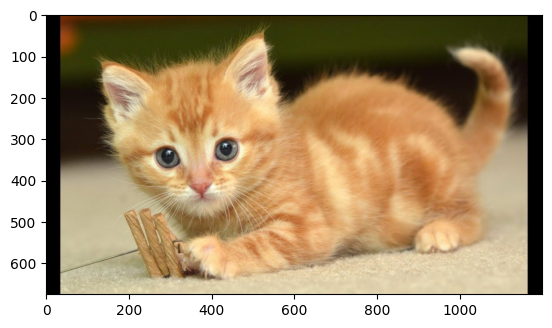

In [45]:
# Make prediction
import matplotlib.pyplot as plt
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]
plt.imshow(image)
with torch.no_grad():
    model_output = model(input_image)
    _, predicted_class = torch.max(model_output, 1)

predicted_class_index = predicted_class.item()
predicted_class_name = class_names[predicted_class_index]

print(f'Predicted class: {predicted_class_index} - {predicted_class_name}')

## Summary
When working with a small dataset, it is usual to use features learnt from a model trained on a bigger dataset in the same domain. This is accomplished by instantiating the pre-trained model and layering a fully connected classifier on top. The pre-trained model is "**frozen**," which means that only the classifier's weights change during training.

The convolutional base retrieved every feature associated with each picture, and we then trained a classifier to determine the image class using that set of extracted features.